[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/deepdream-image.ipynb)

# Deep Dream

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
#!kill -9 -1

## Check Tensorflow Version

In [0]:
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'1.9.0'

In [5]:
tf.keras.__version__

'2.1.6-tf'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras.applications import inception_v3
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing import image
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [0]:
# disable training of the models
K.set_learning_phase(0)

## Import Inception V3 Model Without The Head

In [8]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 15s 0us/step


In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

# Define Loss

In [0]:
layer_contribs = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)

for l_name in layer_contribs:
  coeff = layer_contribs[l_name]
  activation = layer_dict[l_name].output
  
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [0]:
dream_img = model.input

In [0]:
grads = K.gradients(loss, dream_img)[0]

In [0]:
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

In [0]:
outputs = [loss, grads]

In [0]:
get_outputs = K.function([dream_img], outputs)

## Utility Functions

In [0]:
def eval_outputs(x):
  outs = get_outputs([x])
  loss_val = outs[0]
  grad_val = outs[1]
  return loss_val, grad_val

In [0]:
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_val, grad_val = eval_outputs(x)
    if max_loss is not None and loss_val > max_loss:
        break
    x += step * grad_val
  return x

In [0]:
def resize_img(img, size):
  img = np.copy(img)
  factors = (1,
             float(size[0]) / img.shape[1],
             float(size[1]) / img.shape[2],
             1)
  return scipy.ndimage.zoom(img, factors, order=1)

In [0]:
def preprocess_image_to_tensor(image_path):
  img = image.load_img(image_path)
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor = inception_v3.preprocess_input(img_tensor)
  return img_tensor

In [0]:
def save_img(img, fname):
  img = process_tensor_to_img(np.copy(img))
  scipy.misc.imsave(fname, img)

In [0]:
def process_tensor_to_img(img_tensor):
  if K.image_data_format() == 'channels_first':
    img_tensor = img_tensor.reshape((3, img_tensor.shape[2], img_tensor.shape[3]))
    img_tensor = img_tensor.transpose((1, 2, 0))
  else:
    img_tensor = img_tensor.reshape((img_tensor.shape[1], img_tensor.shape[2], 3))
  img_tensor /= 2.
  img_tensor += 0.5
  img_tensor *= 255.
  img = np.clip(img_tensor, 0, 255).astype('uint8')
  return img

## Deep Dream Image

In [0]:
step = 0.01  
num_octave = 3  
octave_scale = 1.4  
iterations = 20  
max_loss = 10.

### Import the image

In [42]:
from google.colab import files
files.upload()

Saving sample.jpg to sample.jpg


{'sample.jpg': b'\xff\xd8\xff\xe1\x0bVhttp://ns.adobe.com/xap/1.0/\x00<?xpacket begin=\'\xef\xbb\xbf\' id=\'W5M0MpCehiHzreSzNTczkc9d\'?>\n<x:xmpmeta xmlns:x=\'adobe:ns:meta/\' x:xmptk=\'Image::ExifTool 9.74\'>\n<rdf:RDF xmlns:rdf=\'http://www.w3.org/1999/02/22-rdf-syntax-ns#\'>\n\n <rdf:Description rdf:about=\'\'\n  xmlns:dc=\'http://purl.org/dc/elements/1.1/\'>\n  <dc:description>\n   <rdf:Alt>\n    <rdf:li xml:lang=\'x-default\'>mountain</rdf:li>\n   </rdf:Alt>\n  </dc:description>\n </rdf:Description>\n</rdf:RDF>\n</x:xmpmeta>\n                                                                                                    \n                                                                                                    \n                                                                                                    \n                                                                                                    \n                                                       

In [0]:
base_image_path = '/content/sample.jpg'
img_tensor = preprocess_image_to_tensor(base_image_path)

In [45]:
img_tensor.shape

(1, 800, 1200, 3)

In [0]:
orig_shape = img_tensor.shape[1:3]

successive_shapes = [orig_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in orig_shape])
  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

orig_img = np.copy(img_tensor)
shrunk_orig_img = resize_img(img_tensor, successive_shapes[0])

for shape in successive_shapes:
  img_tensor = resize_img(img_tensor, shape)
  img_tensor = gradient_ascent(img_tensor,
                        iterations=iterations,
                        step=step,
                        max_loss=max_loss)
  upscaled_shrunk_orig_img = resize_img(shrunk_orig_img, shape)
  same_size_orig = resize_img(orig_img, shape)
  lost_detail = same_size_orig - upscaled_shrunk_orig_img

  img_tensor += lost_detail
  shrunk_orig_img = resize_img(orig_img, shape)
  save_img(img_tensor, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img_tensor, fname='dream.png')

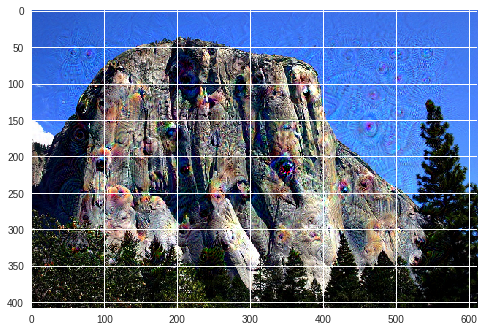

In [49]:
plt.imshow(process_tensor_to_img(np.copy(img_tensor)))